In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from collections import Counter
import re

# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS 

import string
# !pip install nltk
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

#!pip install matplotlib-venn
from matplotlib_venn import venn2, venn2_circles

In [2]:
train = pd.read_excel('data/Constraint_English_Train.xlsx')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6420 non-null   int64 
 1   tweet   6420 non-null   object
 2   label   6420 non-null   object
dtypes: int64(1), object(2)
memory usage: 150.6+ KB


In [3]:
val = pd.read_excel('data/Constraint_English_Val.xlsx')
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2140 non-null   int64 
 1   tweet   2140 non-null   object
 2   label   2140 non-null   object
dtypes: int64(1), object(2)
memory usage: 50.3+ KB


In [4]:
entire = pd.concat([train, val])
entire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8560 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8560 non-null   int64 
 1   tweet   8560 non-null   object
 2   label   8560 non-null   object
dtypes: int64(1), object(2)
memory usage: 267.5+ KB


In [5]:
print(train['label'].value_counts())
print(val['label'].value_counts())
print(entire['label'].value_counts())

real    3360
fake    3060
Name: label, dtype: int64
real    1120
fake    1020
Name: label, dtype: int64
real    4480
fake    4080
Name: label, dtype: int64


DATASET FAKE/REAL TWEETS: 
 label
fake    3060
real    3360
Name: tweet, dtype: int64


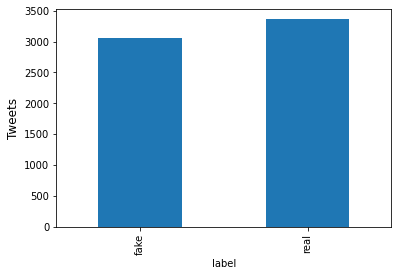

In [6]:
# dataset: fake/real tweets distribution
print('\033[1m'+'DATASET FAKE/REAL TWEETS:'+'\033[0m \n',train.groupby(['label'])['tweet'].count())
train.groupby(['label'])['tweet'].count().plot(kind="bar").set_ylabel("Tweets",fontsize="12")
plt.show()

In [7]:
combined = entire['tweet']
fake = entire[entire['label'] == 'fake']['tweet']
real = entire[entire['label'] == 'real']['tweet']

In [8]:
print('Average length of REAL tweets:', sum(len(x) for x in real) / len(real))
print('Average length of FAKE tweets:', sum(len(x) for x in fake) / len(fake))
print('Average length of ALL tweets:', sum(len(x) for x in combined) / len(combined))

Average length of REAL tweets: 215.37433035714287
Average length of FAKE tweets: 143.51519607843136
Average length of ALL tweets: 181.12371495327102


In [9]:
print('Average number of tokens for REAL tweets', sum(len(x.split()) for x in real) / len(real))
print('Average number of tokens for FAKE tweets:', sum(len(x.split()) for x in fake) / len(fake))
print('Average number of tokens for ALL tweets:', sum(len(x.split()) for x in combined) / len(combined))

Average number of tokens for REAL tweets 31.74575892857143
Average number of tokens for FAKE tweets: 21.679411764705883
Average number of tokens for ALL tweets: 26.947780373831776


# Tokenization & Cleaning

In [10]:
# Function to concatenate and clean all tweets

def concat_clean_tweets(sents):
    
    all_tokens = ''
    
    for text in sents:
      
        tx = str(text).lower().strip()
        tx = tx.replace('\n',' ')
        tx = re.sub('[%s]' % string.punctuation,'',tx)
        #tx = tx.translate(str.maketrans("","", string.punctuation))
        tx = tx.replace('&amp',' ')
        tx = tx.replace('ー','')
        tx = " ".join(tx.split())
        all_tokens += tx + " "
        
    return all_tokens

In [11]:
# Defining stopwords for filtering 

stopwords = set().union(stopwords.words('english'),STOPWORDS) # nltk stopwords + STOPWORDS

link_stopwords = ('https', 'http', 'www') # Stopwords for url strings

In [12]:
# Concatenate and clean tweets

real_cclean = concat_clean_tweets(real)
fake_cclean = concat_clean_tweets(fake)
all_cclean = real_cclean + " " + fake_cclean

In [13]:
# Function to tokenize text and filter out stopword and url

def filter_stops(text):
    
    tokens = text.split()
    tokens = [t for t in tokens if not t.startswith(link_stopwords) and t not in stopwords]
    
    return tokens

In [14]:
# filter out stopwords and url

real_tokens_filtered = filter_stops(real_cclean)
fake_tokens_filtered = filter_stops(fake_cclean)
all_tokens_filtered = real_tokens_filtered + fake_tokens_filtered

print('N° words REAL:', len(real_tokens_filtered))
print('N° words FAKE:', len(fake_tokens_filtered))
print('N° total words:', len(all_tokens_filtered))

#real = re.sub('(?:\s)https[^, ]*', "", str(real_tokens))

N° words REAL: 87753
N° words FAKE: 54431
N° total words: 142184


# Visualization 

In [15]:
# Chart to visualize intersection between tokens REAL and FAKE
def intersection_plot_venn(title, real_t, fake_t,tot):
    
    plt.figure(
        figsize = (9, 7)
        ).suptitle(title, fontsize = 20)
    
    venn2(
        [set(real_t), set(fake_t)],
        set_labels = ('REAL tokens' ,'FAKE tokens'),
        subset_label_formatter = lambda x: str(x) + '\n(' + f'{(x/len(set(tot))):1.0%}' + ')',
        alpha = 0.55,
        )
    venn2_circles(
        [set(real_t), set(fake_t)],
        lw = 0.2
        )
    plt.show()
    

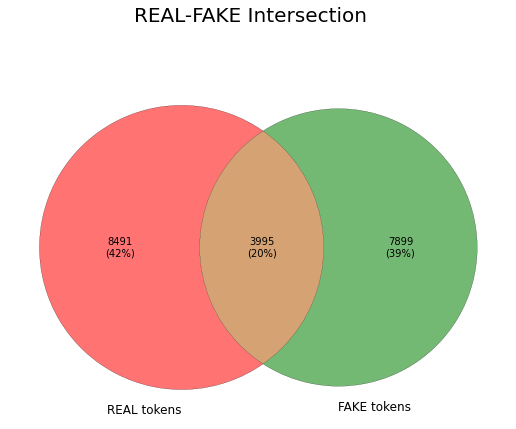

Unique tokens REAL: 12486
Unique tokens FAKE: 11894
ALL unique tokens: 20385
Real/Fake common unique tokens: 3995


In [16]:
#  Visualization of the intersection between tokens REAL and FAKE

intersection_plot_venn('REAL-FAKE Intersection', real_tokens_filtered, fake_tokens_filtered, all_tokens_filtered)

print('\033[91m\033[1m' + 'Unique tokens REAL:' + '\033[0m', len(set(real_tokens_filtered)))
print('\033[92m\033[1m' + 'Unique tokens FAKE:'+'\033[0m', len(set(fake_tokens_filtered)))
print('\033[1m' + 'ALL unique tokens:'+'\033[0m',len(set(all_tokens_filtered)))
print('\033[93m\033[1m'+'Real/Fake common unique tokens:'+'\033[0m', len(set(real_tokens_filtered).intersection(set(fake_tokens_filtered))))

In [17]:
# To create a wordcloud from a list of tokens

def create_wordcloud(tokens):
    
    wordcloud = WordCloud(
        width = 400,
        height = 400, 
        background_color ='white', 
        stopwords = stopwords, 
        min_font_size = 10 
        ).generate(' '.join(tokens))
    
    return wordcloud

In [18]:
# To display a list of wordclouds

def display_wordcloud(wordclouds):
    
    plt.figure(figsize = (30,10))
    j = len(wordclouds[0])
    
    for t in range(len(wordclouds[0])):
        i = t + 1
        plt.subplot(1, 3, i).set_title(wordclouds[1][t], fontsize = 25)
        plt.plot()
        plt.imshow(wordclouds[0][t])
        plt.axis("off")
        
    plt.suptitle("WordCloud Comparison", fontsize=30)
    
    plt.show()
    

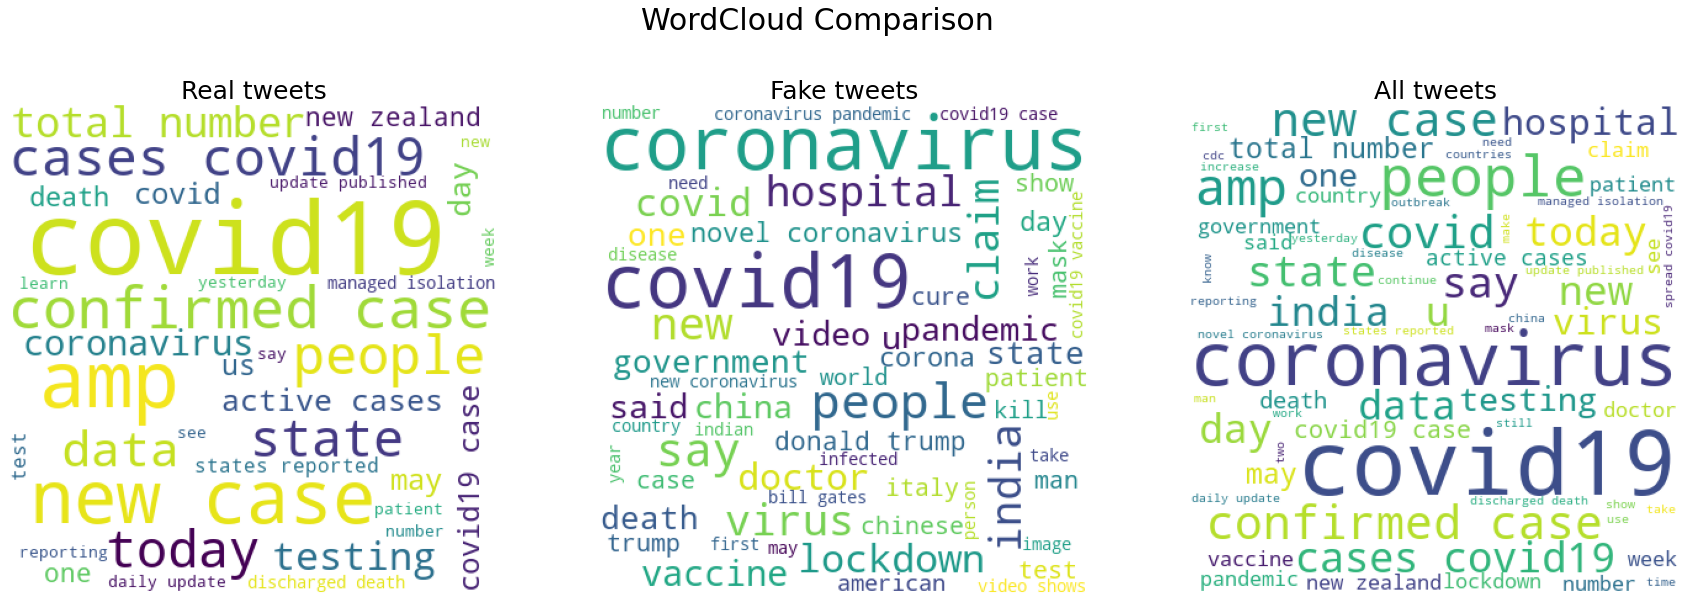

In [19]:
# Visualization of wordclouds

wordcloud_list = [create_wordcloud(real_tokens_filtered), create_wordcloud(fake_tokens_filtered), create_wordcloud(all_tokens_filtered)]
wordcloud_titles = ['Real tweets', 'Fake tweets', 'All tweets']
wordclouds = [wordcloud_list, wordcloud_titles]

display_wordcloud(wordclouds)


In [20]:
# Most frequent tokens
frequent_real = Counter(real_tokens_filtered).most_common(20)
frequent_fake = Counter(fake_tokens_filtered).most_common(20)
frequent_all = Counter(all_tokens_filtered).most_common(20)

In [21]:
# Chart to visualize frequent tokens


def plot_frequent_tokens(title, common, c):
    
    title = 'Most frequent words in ' + title + ' tweets'
    
    words, occurrences = zip(*common) # save the words and their respective occurrences separately
    
    y= np.arange(len(words))# label locations
    
    # Fig. and bars creation
    fig, ax = plt.subplots(figsize = (16, 12))
    width=0.9
    
    rects = ax.barh(y, occurrences, width, color= c)
    
    # Add grid, text for labels, title and custom y-axis tick labels, etc.
    ax.grid(b = True, color = 'grey',
                linestyle = '-.', linewidth = 0.5,
                alpha = 0.4)
    
    ax.set_xlabel('Occurrences').set_fontsize(15)
    ax.set_title(title).set_fontsize(25)
    
    ax.set_yticks(y)
    ax.set_yticklabels(words, fontsize = 17)
    ax.yaxis.label.set_fontsize(20)
    
    ax.invert_yaxis() # descending order
    
    ax.bar_label(rects, padding = 2, fontsize = 16)
    
    fig.tight_layout()
    
    plt.show()
    

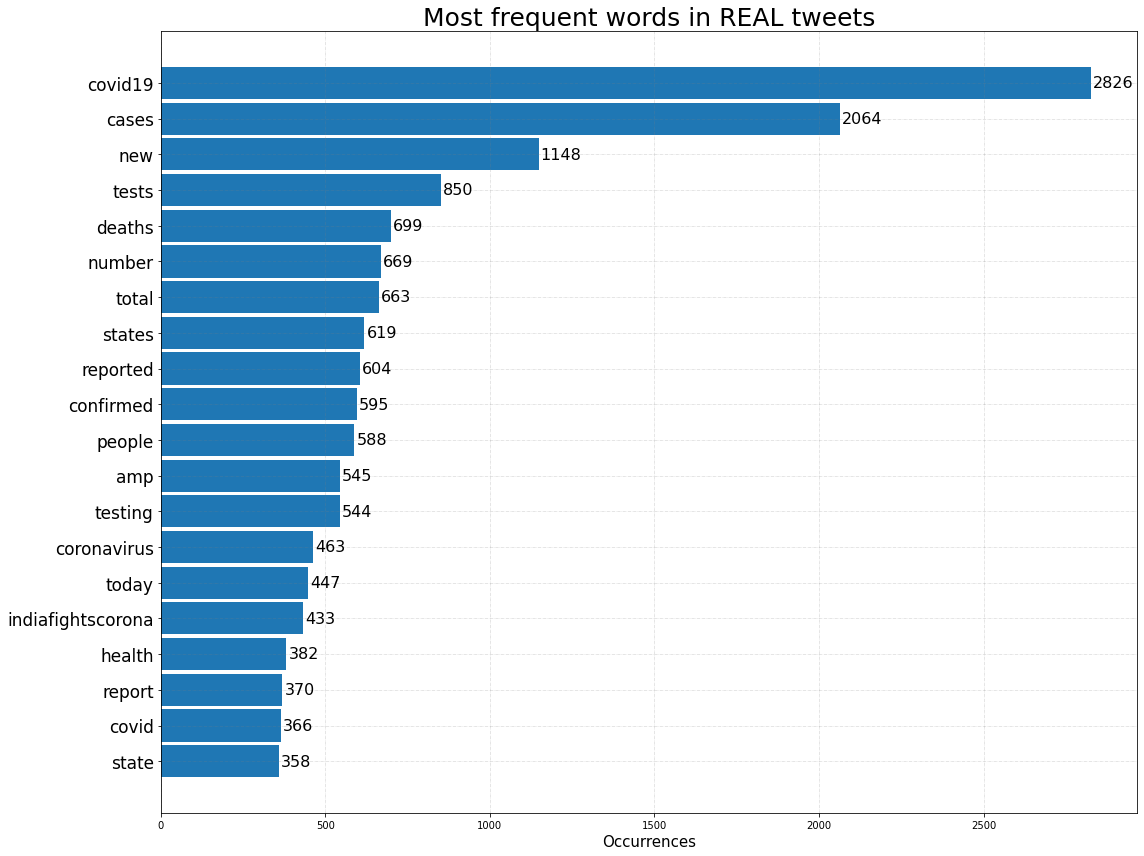

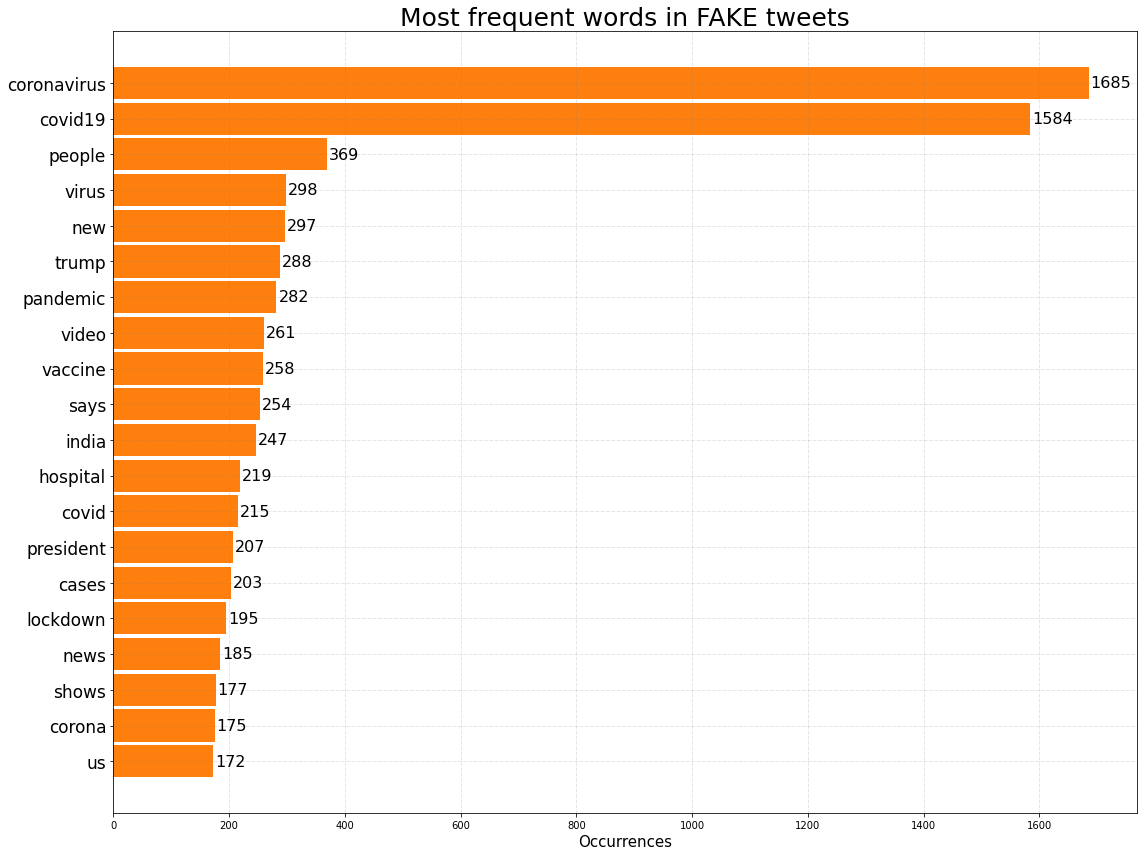

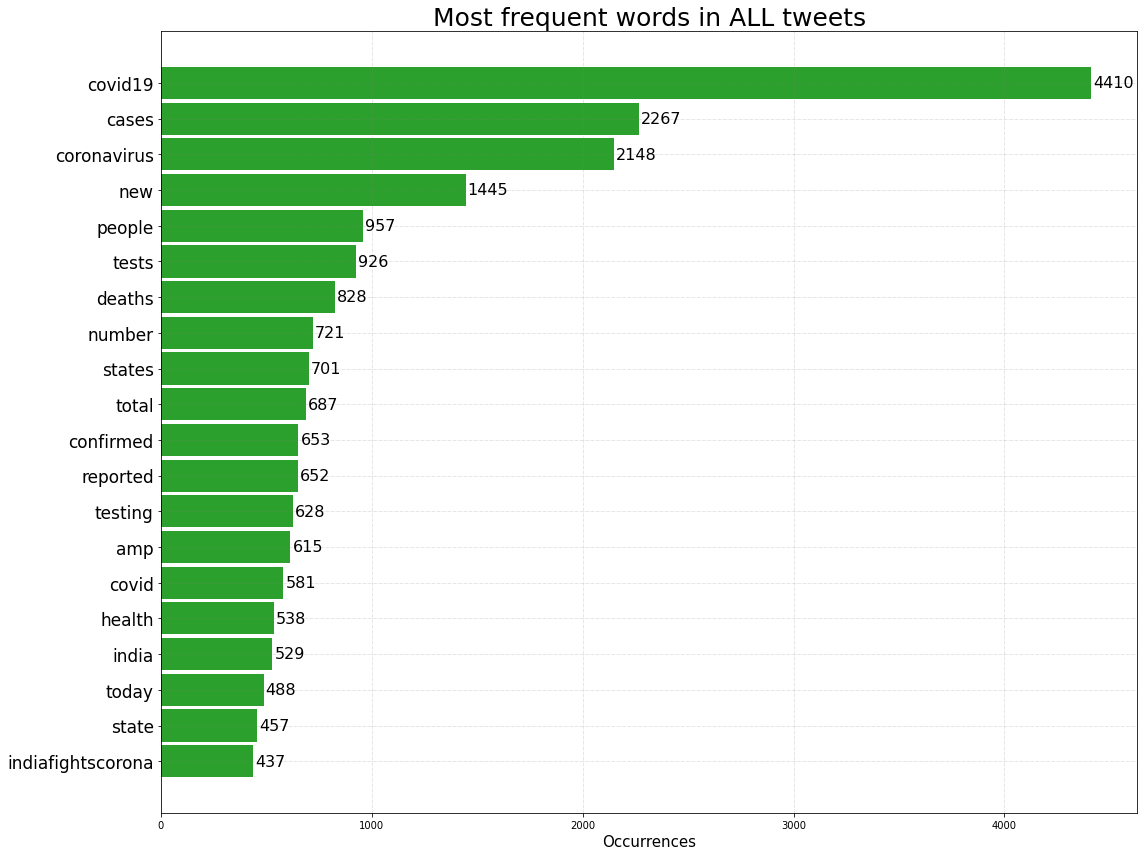

In [22]:
# Visualization of the most frequent tokens REAL, FAKE and ALL

plot_frequent_tokens('REAL', frequent_real, 'tab:blue')
plot_frequent_tokens('FAKE', frequent_fake, 'tab:orange')
plot_frequent_tokens('ALL', frequent_all, 'tab:green')


In [23]:
# Intersection between the most frequent tokens REAL/FAKE

intersaction = [(item1[0],item1[1],item2[1]) for item1 in frequent_real for item2 in frequent_fake if item1[0] == item2[0]]


In [24]:
# Chart to compare the most frequent tokens in common

def intersection_survay(intersaction_words):
    
    words, occurrences_real, accurrences_fake = zip(*intersaction) # save the words and their respective occurrences separately
    
    y = np.arange(len(words))  # the label locations
    width = 0.3

    fig, ax = plt.subplots(figsize = (16, 10))
    
    rects1 = ax.barh(y - width / 2, occurrences_real, width, label = 'Real')
    rects2 = ax.barh(y + width / 2, accurrences_fake, width, label = 'Fake')
    
    ax.grid(b = True, color = 'grey',
            linestyle = '-.', linewidth=0.5,
            alpha = 0.4)
    # Add text for labels, title and custom y-axis tick labels, etc.
    ax.set_xlabel('Occurrences').set_fontsize(15)
    ax.set_title('Comparison most frequent tokens in common REAL/FAKE').set_fontsize(25)
    ax.set_yticks(y)
    ax.set_yticklabels(words, fontsize = 17)
    ax.invert_yaxis()
    
    ax.legend(prop = {"size" : 18})

    ax.bar_label(rects1, padding = 2, fontsize = 16)
    ax.bar_label(rects2, padding = 2, fontsize = 16)

    fig.tight_layout()

    plt.show()


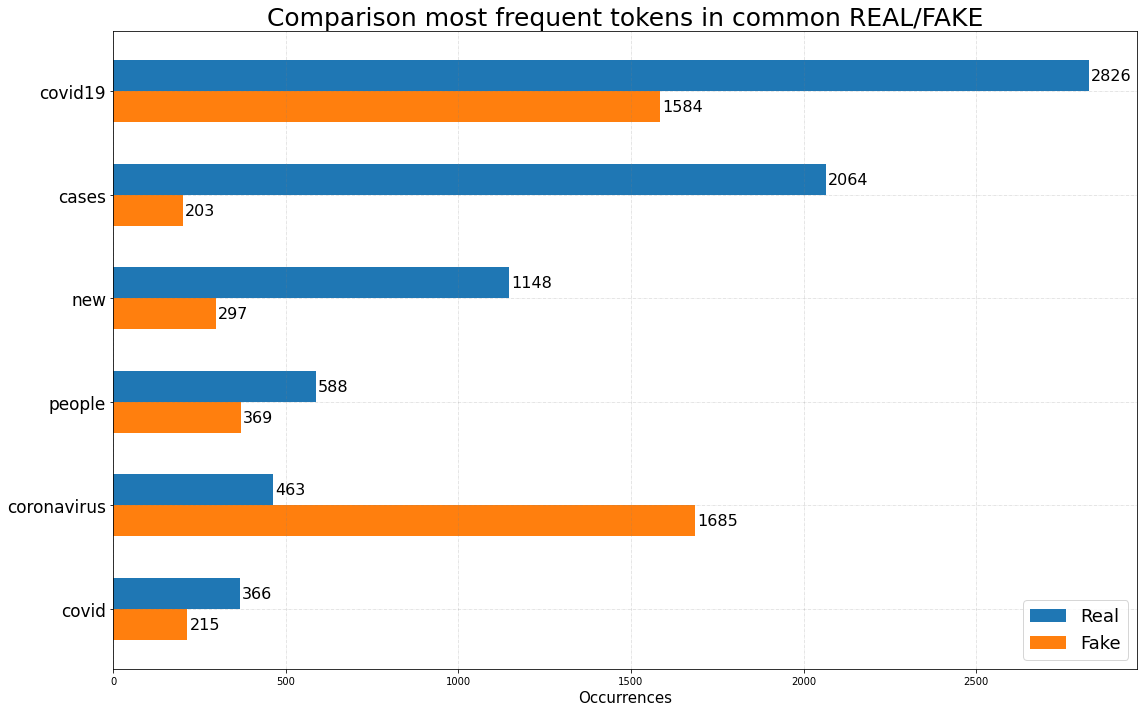

In [25]:
# Visualization of the most frequent tokens in common 

intersection_survay(intersaction)